<a href="https://colab.research.google.com/github/harshitgupta5/Coursera_Capstone/blob/master/The_Battle_of_Neighbourhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Capstone Project - The Battle of Neighborhoods
##Introduction
New York is the most populous city in the United States. With an estimated 2019 population of 8,336,817 distributed over about 302.6 square miles , New York is also the most densely populated major city in the United States. Located at the southern tip of the U.S. state of New York, the city is the center of the New York metropolitan area, the largest metropolitan area in the world by urban landmass. With almost 20 million people in its metropolitan statistical area and approximately 23 million in its combined statistical area, it is one of the world's most populous megacities. New York City has been described as the cultural, financial, and media capital of the world, significantly influencing commerce, entertainment, research, technology, education, politics, tourism, art, fashion, and sports. 

New York City is sometimes referred to collectively as the five boroughs.

There are hundreds of distinct neighborhoods throughout the boroughs, many with a definable history and character. If the boroughs were each independent cities, four of the boroughs (Brooklyn, Queens, Manhattan, and the Bronx) would be among the ten most populous cities in the United States (Staten Island would be ranked 37th); these same boroughs are coterminous with the four most densely populated counties in the United States: New York (Manhattan), Kings (Brooklyn), Bronx, and Queens.

New York City's food culture includes an array of international cuisines influenced by the city's immigrant history. Central and Eastern European immigrants, especially Jewish immigrants from those regions, brought bagels, cheesecake, hot dogs, knishes, and delicatessens (or delis) to the city. The New York City Department of Health and Mental Hygiene assigns letter grades to the city's restaurants based upon their inspection results. As of 2019, there were 27,043 restaurants in the city, up from 24,865 in 2017. 

With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Indian , French etc.

So as part of this project , we will list and visualize all major parts of New York City that has great chinese resturants.

## Data
### Data Sources 
For this project we need the following data :
* New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
>* Data source : https://cocl.us/new_york_dataset
>* Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
* Chinese resturants in each neighborhood of new york city.
>* Data source : Fousquare API
>* Description : By using this api we will get all the venues in each neighborhood. We will  filter these to get only chinese resturants.
* GeoSpace data
>* Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
>* Description : By using this  data we will get the New york Borough boundaries that will help us in visualizing choropleth map.

### How the data will be used?
* We will Collect the new york city data from https://cocl.us/new_york_dataset
* Using FourSquare API we will find all venues for each neighborhood.
* Well will filter out all chinese restaurants.
* We will find rating , tips and like count for each chinese Resturants using FourSquare API.
* Using rating for each resturant , we will sort that data.
* Visualize the Ranking of neighborhoods using folium library(python)

### What all we will get?
* Best location in New York for Chinese Cuisine
* Area having potential Chinese Restaurant Market
* Areas lacking Chinese restaurants
* Best place to stay if one prefers Chinese Cuisine

### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
!pip install geocoder
import geocoder
import os
import folium
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors

     |████████████████████████████████| 102kB 2.3MB/s 


### Function to get latitude and longitude of a given location

In [0]:
def geo_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

### Function to interact with FourSquare API

In [0]:
def get_venues(lat,lng):
    
    radius=1000
    LIMIT=100
    CLIENT_ID = ''
    CLIENT_SECRET = ''
    VERSION = '' 
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()
    if 'groups' not in results["response"]:
        return pd.DataFrame()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Function to get venue details

In [0]:
def get_venue_details(venue_id):        
    CLIENT_ID = '' 
    CLIENT_SECRET =''
    VERSION = '' # Foursquare API version
    
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    results = requests.get(url).json()
    print(results['response'].keys())
    if 'venue' not in results['response'].keys():
        return pd.DataFrame()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Function to get New York City Data

In [0]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [0]:
new_york_data=get_new_york_data()

In [8]:
new_york_data.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [9]:
new_york_data.shape

(306, 4)

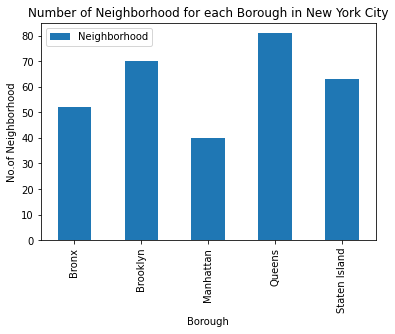

In [10]:
plt.title('Number of Neighborhood for each Borough in New York City')
plt.xlabel('Borough')
plt.ylabel('No.of Neighborhood')
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

### Collectiong Chinese Restaurants for each neighbourhood

In [21]:
# prepare neighborhood list that contains chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude) 
    if venues.empty==False:
        chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
        print('(',count,'/',len(new_york_data),')','Chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
        for resturant_detail in chinese_resturants.values.tolist():
            id, name , category=resturant_detail
            chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                    'Neighborhood': Neighborhood, 
                                                    'ID': id,
                                                    'Name' : name
                                                }, ignore_index=True)
        count+=1


( 1 / 306 ) Chinese Resturants in Wakefield, Bronx:2
( 2 / 306 ) Chinese Resturants in Co-op City, Bronx:2
( 3 / 306 ) Chinese Resturants in Eastchester, Bronx:0
( 4 / 306 ) Chinese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Chinese Resturants in Riverdale, Bronx:0
( 6 / 306 ) Chinese Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Chinese Resturants in Marble Hill, Manhattan:2
( 8 / 306 ) Chinese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Chinese Resturants in Norwood, Bronx:4
( 10 / 306 ) Chinese Resturants in Williamsbridge, Bronx:1
( 11 / 306 ) Chinese Resturants in Baychester, Bronx:4
( 12 / 306 ) Chinese Resturants in Pelham Parkway, Bronx:3
( 13 / 306 ) Chinese Resturants in City Island, Bronx:1
( 14 / 306 ) Chinese Resturants in Bedford Park, Bronx:3
( 15 / 306 ) Chinese Resturants in University Heights, Bronx:0
( 16 / 306 ) Chinese Resturants in Morris Heights, Bronx:1
( 17 / 306 ) Chinese Resturants in Fordham, Bronx:1
( 18 / 306 ) Chinese Resturants in East Tremont, Bronx:

In [22]:
chinese_rest_ny.head(10)

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4edbac4e775bcc53fc0ed5f8,Hong Kong China King
1,Bronx,Wakefield,4e2710b7a809510950dd6b32,Double Dragon
2,Bronx,Co-op City,4fee4857e4b0f9bd2b5cd611,Chinese Buffet (All You Can Eat)
3,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet
4,Manhattan,Marble Hill,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant
5,Manhattan,Marble Hill,4bcbae5d68f976b01da46183,Ming Moon Buffet
6,Bronx,Norwood,4e2e08021838f1c552b6b8eb,Choi Yuan - Chinese Restaurant
7,Bronx,Norwood,4e4d0387bd413c4cc66dfd72,Hung Hing Chinese Restaurant
8,Bronx,Norwood,4b80a6c6f964a520b98330e3,China One Chinese Restaurant
9,Bronx,Norwood,4f0b1638e4b000dd7818e8fe,Sing Wok Kitchen


In [23]:
chinese_rest_ny.shape

(414, 4)

### Graph for No. of Restaurants for each Borough

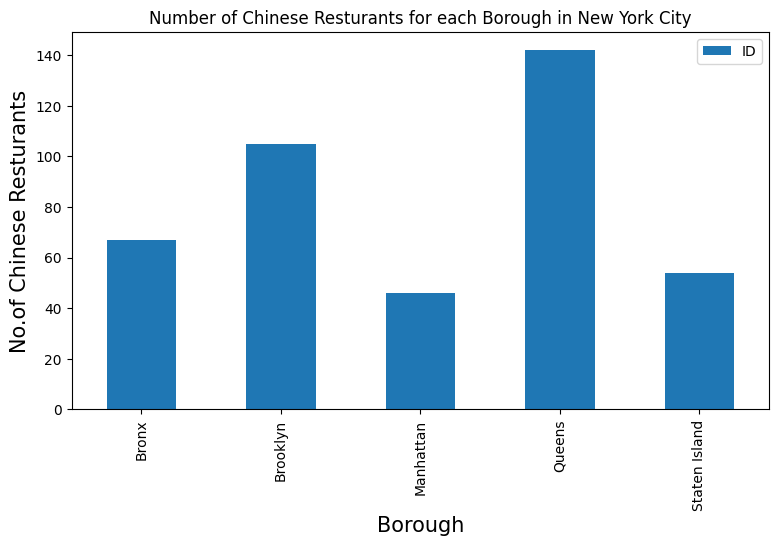

In [25]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Chinese Resturants for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Chinese Resturants', fontsize=15)
chinese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
#displays the plot
plt.show()

### Queens's Graph of top 10 neighboroods as it has largest number of restaurants

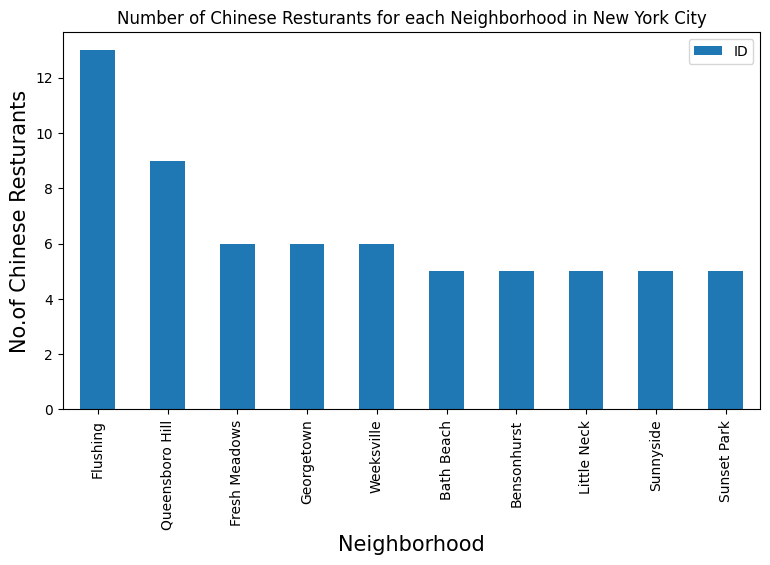

In [28]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Chinese Resturants for each Neighborhood in New York City')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of Chinese Resturants', fontsize=15)
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(10).plot(kind='bar')
plt.legend()
plt.show()

In [31]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Flushing']

,Borough,Neighborhood,ID,Name
191,Queens,Flushing,5747a89b498ee4b7a5106556,DunHuang Lanzhou Beef Noodle
192,Queens,Flushing,52235ea211d2fe55782d764c,Dong Yi Feng
193,Queens,Flushing,4ad50f59f964a520950121e3,Fu Run 賦潤東北美食
194,Queens,Flushing,4c78756397028cfaec16d8fe,New Golden Szechuan Chinese Restaurant
195,Queens,Flushing,4fa3f81be4b0a34ac673bf1e,Taipei Hong 台北夯
196,Queens,Flushing,4abfef82f964a520179320e3,New Imperial Palace 東湖
197,Queens,Flushing,4faff7eae4b03b8055801cde,Xi'an Famous Foods
198,Queens,Flushing,4d1bcddc1356224bc6410abe,OK Ryan
199,Queens,Flushing,4ac38216f964a520929b20e3,Golden Shopping Mall
200,Queens,Flushing,4ef37491d3e32dc398c7c5c7,Laoma Mala Tang


So, we have 13 Chinese Restaurants in Flushing 

### Getting the ranking of each restaurant

In [42]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    if not venue_details.empty:
        print('(',count,'/',len(chinese_rest_ny),')','processed')
        chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                    'Neighborhood': Neighborhood, 
                                                    'ID': id,
                                                    'Name' : name,
                                                    'Likes' : likes,
                                                    'Rating' : rating,
                                                    'Tips' : tips
                                                }, ignore_index=True)
        count+=1

dict_keys(['venue'])
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4edbac4e775bcc53fc0ed5f8
dict_keys(['venue'])
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e2710b7a809510950dd6b32
dict_keys(['venue'])
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4fee4857e4b0f9bd2b5cd611
dict_keys(['venue'])
                         ID            Name  Likes  Rating  Tips
0  4c66dcfaaebea593955a74d0  Chinese Buffet      7     5.0    10
( 1 / 414 ) processed
dict_keys(['venue'])
                         ID                           Name  Likes  Rating  \
0  4d965fd061a3a1cde4989a42  Lucky Star Chinese Restaurant      3     7.4   

   Tips  
0     5  
( 2 / 414 ) processed
dict_keys(['venue'])
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4bcbae5d68f976b01da46183
dict_keys(['venue'])
                         ID     

In [43]:
chinese_rest_stats_ny.head(10)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet,7,5.0,10
1,Manhattan,Marble Hill,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant,3,7.4,5
2,Bronx,Norwood,4e2e08021838f1c552b6b8eb,Choi Yuan - Chinese Restaurant,6,7.0,8
3,Bronx,Norwood,4e4d0387bd413c4cc66dfd72,Hung Hing Chinese Restaurant,5,6.0,2
4,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,9,7.2,10
5,Bronx,City Island,4bfc652bf14fa593c1f5c9d4,City Island Chinese Resturant,6,6.4,4
6,Bronx,Bedford Park,4e2e08021838f1c552b6b8eb,Choi Yuan - Chinese Restaurant,6,7.0,8
7,Bronx,Bedford Park,4e4d0387bd413c4cc66dfd72,Hung Hing Chinese Restaurant,5,6.0,2
8,Bronx,Fordham,566f33e7498e44c2501bda81,Panda Express,12,7.6,2
9,Bronx,Melrose,4ce9aeae678aa093b7a0efea,Merry Land Buffet,12,6.6,3


In [44]:
chinese_rest_stats_ny.shape

(167, 7)

### Saving to a **csv** File

In [0]:
chinese_rest_stats_ny.to_csv('chinese_rest_stats_ny.csv', index=False)

### Reading from **csv** file

In [0]:
chinese_rest_stats_ny_csv=pd.read_csv('chinese_rest_stats_ny.csv')

In [48]:
chinese_rest_stats_ny_csv.shape

(167, 7)

In [50]:
chinese_rest_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       167 non-null    object 
 1   Neighborhood  167 non-null    object 
 2   ID            167 non-null    object 
 3   Name          167 non-null    object 
 4   Likes         167 non-null    int64  
 5   Rating        167 non-null    float64
 6   Tips          167 non-null    int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 9.3+ KB


In [51]:
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       167 non-null    object 
 1   Neighborhood  167 non-null    object 
 2   ID            167 non-null    object 
 3   Name          167 non-null    object 
 4   Likes         167 non-null    float64
 5   Rating        167 non-null    float64
 6   Tips          167 non-null    float64
dtypes: float64(3), object(4)
memory usage: 9.3+ KB


### Resturant with maximum Likes

In [53]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              4e3484038877beb5e9a22a0b
Name                          Café China
Likes                               1045
Rating                               8.8
Tips                                 273
Name: 67, dtype: object

### Resturant with maximum Rating

In [54]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood             Lower East Side
ID              5b380f649deb7d00399fdf9d
Name               Kings County Imperial
Likes                                 67
Rating                               9.2
Tips                                  10
Name: 71, dtype: object

### Resturant with maximum Tips

In [55]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              4e3484038877beb5e9a22a0b
Name                          Café China
Likes                               1045
Rating                               8.8
Tips                                 273
Name: 67, dtype: object

### Neighborhood Visualisation with Max average rating

In [145]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
61,Lower East Side,9.20
44,Greenpoint,9.00
75,North Side,8.90
66,Marine Park,8.90
46,Greenwich Village,8.80
68,Midtown,8.80
72,Murray Hill,8.75
69,Midtown South,8.70
88,Rugby,8.70
97,Upper West Side,8.60


### Visualisation of Average Rating for each Borough

In [58]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False)

,Borough,Average Rating
2,Manhattan,8.096667
1,Brooklyn,7.348980
3,Queens,7.124561
4,Staten Island,6.871429
0,Bronx,6.723529


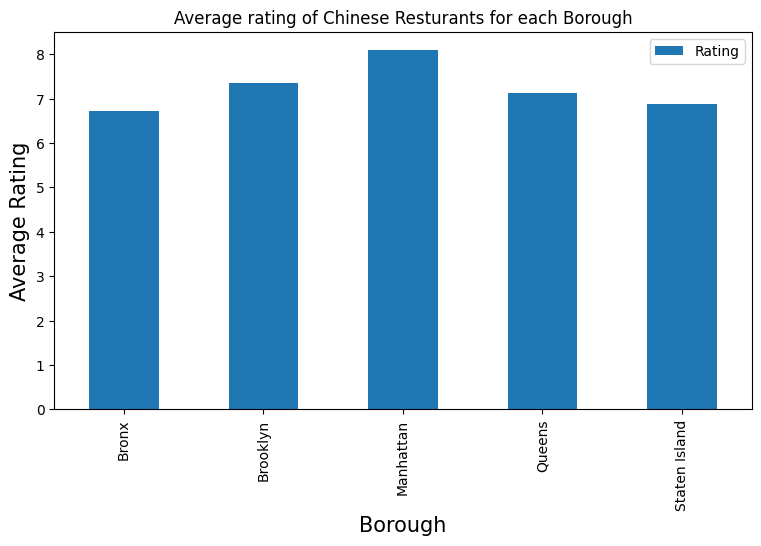

In [59]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Chinese Resturants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')#legend
plt.legend()
plt.show()

Considering all Neigborhoods with average rating greater than 8.0

In [86]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
17,Chinatown,8.200
21,College Point,8.100
26,Dongan Hills,8.100
31,Elmhurst,8.025
33,Far Rockaway,8.400
41,Gramercy,8.100
44,Greenpoint,9.000
46,Greenwich Village,8.800
59,Little Italy,8.500
61,Lower East Side,9.200


### Displaying the Restaurants on Map

In [0]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [67]:
ny_neighborhood_stats

,Neighborhood,Average Rating
17,Chinatown,8.200
21,College Point,8.100
26,Dongan Hills,8.100
31,Elmhurst,8.025
33,Far Rockaway,8.400
41,Gramercy,8.100
44,Greenpoint,9.000
46,Greenwich Village,8.800
59,Little Italy,8.500
61,Lower East Side,9.200


In [0]:
ny_neighborhood_loc = ny_neighborhood_stats

In [146]:
incidents = folium.map.FeatureGroup()
ny_neighborhood_stats = ny_neighborhood_loc
ny_neighborhood_stats['Latitude'] = [np.nan] * len(ny_neighborhood_stats)
ny_neighborhood_stats['Longitude'] = [np.nan] * len(ny_neighborhood_stats)
ny_neighborhood_stats['Borough'] = [np.nan] * len(ny_neighborhood_stats)
loc = dict()
y = []
for index in ny_neighborhood_stats.index:
    # print(ny_neighborhood_stats[index])
    x = new_york_data.where(new_york_data['Neighborhood']==ny_neighborhood_stats['Neighborhood'][index]).dropna(    )
    x = x.dropna()
    for index in x.index:
        y.append(x.loc[index])
    # y.append([x[:][index] for index in x.index])
    # y.append(new_york_data.where(new_york_data['Neighborhood']==ny_neighborhood_stats['Neighborhood'][index]))
    # x = x.dropna()
    # y.append(x[:])
    ny_neighborhood_stats['Latitude']
y=pd.DataFrame(y)
# print(y)
y = y.drop([115])
# print( len(y[:]['Latitude']) )
# lat = y[:]['Latitude'].tolist())
# print(len(ny_neighborhood_stats['Latitude']))
ny_neighborhood_stats['Latitude'] = y[:]['Latitude'].tolist()
ny_neighborhood_stats['Longitude'] = y[:]['Longitude'].tolist() 
ny_neighborhood_stats['Borough'] = y[:]['Borough'].tolist() 
print(ny_neighborhood_stats)
    # ny_neighborhood_stats['Latitude'][index] = new_york_data['Latitude'].where(new_york_data['Neighborhood']==ny_neighborhood_stats['Neighborhood'][index])

# ny_neighborhood_loc = pd.DataFrame(new_york_data.where(new_york_data['Neighborhood'] == ny_neighborhood_stats['Neighborhood']))
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, 
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

            Neighborhood  Average Rating   Latitude  Longitude        Borough
17             Chinatown           8.200  40.715618 -73.994279      Manhattan
21         College Point           8.100  40.784903 -73.843045         Queens
26          Dongan Hills           8.100  40.588673 -74.096399  Staten Island
31              Elmhurst           8.025  40.744049 -73.881656         Queens
33          Far Rockaway           8.400  40.603134 -73.754980         Queens
41              Gramercy           8.100  40.737210 -73.981376      Manhattan
44            Greenpoint           9.000  40.730201 -73.954241       Brooklyn
46     Greenwich Village           8.800  40.726933 -73.999914      Manhattan
59          Little Italy           8.500  40.719324 -73.997305      Manhattan
61       Lower East Side           9.200  40.717807 -73.980890      Manhattan
62      Manhattan Valley           8.100  40.797307 -73.964286      Manhattan
66           Marine Park           8.900  40.609748 -73.931344  

In [0]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

### Adding Popup text to each marker

In [0]:
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

## Visualizing the Neigborhoods

In [149]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Conclusion
* Greenpoint, Lower East Side are some of the best neighborhoods for chinese cuisine.
* Manhattan has potential Chinese Resturant Market
* Manhattan is the best place to stay if you prefer Chinese Cuisine.

## Limitations
* The accuracy of data depends purely depends on the data provided by FourSquare
* The ranking is purely on basis of rating of resturants